In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from env import get_db_url

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)


In [3]:
# Pull down curriculum logs data from SQL server
url = get_db_url('curriculum_logs')
query = 'SELECT * FROM logs'

df = pd.read_sql(query, url)

# Check data
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       900223 non-null  object 
 1   time       900223 non-null  object 
 2   path       900222 non-null  object 
 3   user_id    900223 non-null  int64  
 4   cohort_id  847330 non-null  float64
 5   ip         900223 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 41.2+ MB


In [6]:
# Copy curriculum logs data to CSV (because it's kind of a big dataset)
df.to_csv('curriculum_logs.csv')



In [41]:
# Make function query for acquire.py module
import os

def get_curriculum_logs():
    filename = 'curriculum_logs.csv'
    if os.path.exists(filename):
        print('Reading from CSV...')
        return pd.read_csv(filename)

    query = 'SELECT * FROM logs'
    print('Getting a fresh copy from SQL db...')
    url = get_db_url('curriculum_logs')
    df = pd.read_sql(query, url)
    print('Copying to CSV...')
    df.to_csv(filename, index=False)
    return df


In [42]:
# Check head of data
df = get_curriculum_logs()
df.info()
df.head()

Reading from CSV...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  900223 non-null  int64  
 1   date        900223 non-null  object 
 2   time        900223 non-null  object 
 3   path        900222 non-null  object 
 4   user_id     900223 non-null  int64  
 5   cohort_id   847330 non-null  float64
 6   ip          900223 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 48.1+ MB


,Unnamed: 0,date,time,path,user_id,cohort_id,ip
0,0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [43]:
# Wrangle df
df = df.drop(columns= ['Unnamed: 0'])
df['timestamp'] = df['date'] + ' ' + df['time']
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index(df.timestamp)

# Drop unnecessary columns (now that 'timestamp' is set as index)
df = df.drop(columns= ['date', 'time', 'timestamp'])
df = df.dropna()
# Check df
df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       900223 non-null  object        
 1   time       900223 non-null  object        
 2   path       900222 non-null  object        
 3   user_id    900223 non-null  int64         
 4   cohort_id  847330 non-null  float64       
 5   ip         900223 non-null  object        
 6   timestamp  900223 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 54.9+ MB


,date,time,path,user_id,cohort_id,ip,timestamp
timestamp,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [45]:
from prep import get_proportional_splits

train, validate, test = get_proportional_splits(df)

print(train.shape, validate.shape, test.shape)

AssertionError: 

In [2]:

def get_grocery_customers():
    filename = 'grocery_customers.csv'
    if os.path.exists(filename):
        print('Reading from CSV...')
        return pd.read_csv(filename)

    query = 'SELECT * FROM grocery_customers'
    print('Getting a fresh copy from SQL db...')
    url = get_db_url('grocery_db')
    df = pd.read_sql(query, url)
    print('Copying to CSV...')
    df.to_csv(filename, index=False)
    return df


grocery_df = get_grocery_customers()

Getting a fresh copy from SQL db...
Copying to CSV...


In [3]:
grocery_df.info()
grocery_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   customer_id       440 non-null    int64
 1   Channel           440 non-null    int64
 2   Region            440 non-null    int64
 3   Fresh             440 non-null    int64
 4   Milk              440 non-null    int64
 5   Grocery           440 non-null    int64
 6   Frozen            440 non-null    int64
 7   Detergents_Paper  440 non-null    int64
 8   Delicassen        440 non-null    int64
dtypes: int64(9)
memory usage: 31.1 KB


,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# Wrangling

# Change column names to lowercase
grocery_df.columns = [col.lower() for col in grocery_df.columns]

# Rename misspelled delicatessen column ("What is this delikhassen? Do they serve halal meats at this delikhassen?")
grocery_df = grocery_df.rename(columns= {'delicassen': 'deli'})

# Final cleaning: drop customer_id column, cast channel and region columns as dtype 'object'
grocery_df = grocery_df.drop(columns= ['customer_id'])
grocery_df.channel = grocery_df.channel.astype('object')
grocery_df.region = grocery_df.region.astype('object')




Index(['customer_id', 'channel', 'region', 'fresh', 'milk', 'grocery',
       'frozen', 'detergents_paper', 'delicassen'],
      dtype='object')

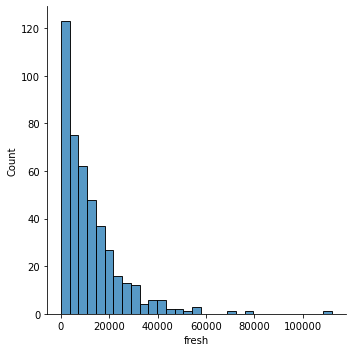

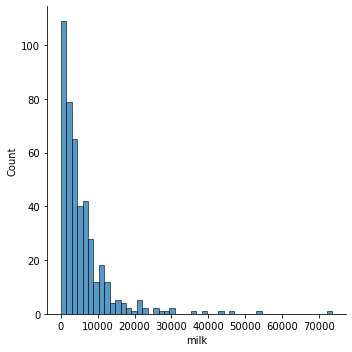

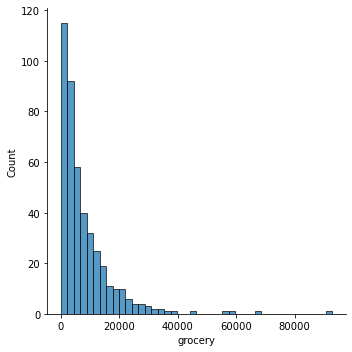

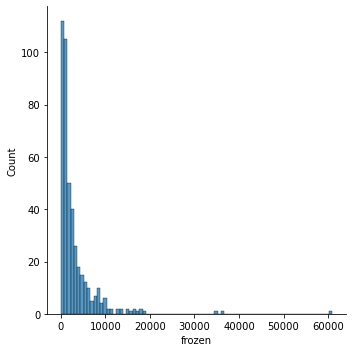

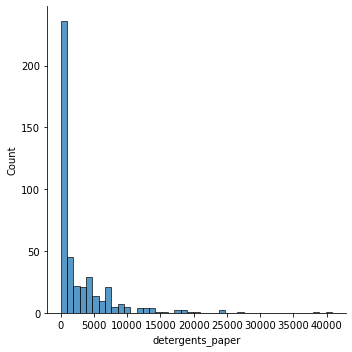

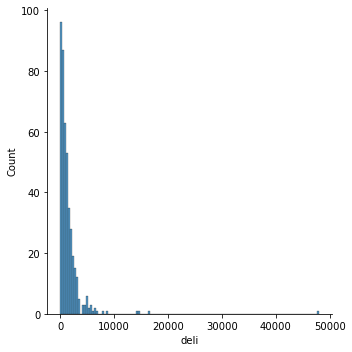

In [9]:
# Viz distributions
for col in grocery_df.select_dtypes(np.int64).columns:
    sns.displot(data=grocery_df, x=grocery_df[col])
    plt.show()

In [10]:
# View summary stats
grocery_df.describe()

,fresh,milk,grocery,frozen,detergents_paper,deli
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [11]:
#Split and scale grocery data

from prep import get_splits, minmax_scale_data

g_train, g_validate, g_test = get_splits(grocery_df)

print(g_train.shape, g_validate.shape, g_test.shape)

g_train_scaled, g_validate_scaled, g_test_scaled = minmax_scale_data(g_train, g_validate, g_test, g_train.select_dtypes(include=np.int64).columns)

g_train_scaled.head()


(246, 8) (106, 8) (88, 8)


,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli
271,1,1,0.027284,0.129248,0.023182,0.017787,0.003780,0.106918
309,2,2,0.012003,0.537662,0.201560,0.023458,0.179611,0.055498
269,1,1,0.199583,0.005298,0.016866,0.040736,0.008662,0.013892
43,2,3,0.008225,0.288145,0.356564,0.012313,0.250033,0.004769
401,1,3,0.356324,0.071671,0.031577,0.216748,0.002336,0.131246


In [12]:
# Make cluster object and fit it to scaled data
dbsc = DBSCAN(eps= .10, min_samples=20)
dbsc.fit(g_train_scaled)

DBSCAN(eps=0.1, min_samples=20)

In [13]:
# Add cluster labels column
g_train_scaled['labels'] = dbsc.labels_

g_train_scaled.labels.value_counts()

-1    168
 0     78
Name: labels, dtype: int64

In [17]:
# Rename scaled df's columns
g_train_scaled.columns = ['scaled_' + col for col in g_train_scaled.columns]

g_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 271 to 419
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   scaled_channel           246 non-null    object 
 1   scaled_region            246 non-null    object 
 2   scaled_fresh             246 non-null    float64
 3   scaled_milk              246 non-null    float64
 4   scaled_grocery           246 non-null    float64
 5   scaled_frozen            246 non-null    float64
 6   scaled_detergents_paper  246 non-null    float64
 7   scaled_deli              246 non-null    float64
 8   scaled_labels            246 non-null    int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 19.2+ KB


In [18]:
# Append scaled df to unscaled train df
g_train = pd.concat([g_train, g_train_scaled], axis=1, ignore_index=False)

g_train.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli,scaled_channel,scaled_region,scaled_fresh,scaled_milk,scaled_grocery,scaled_frozen,scaled_detergents_paper,scaled_deli,scaled_labels
271,1,1,2083,5007,1563,1120,147,1550,1,1,0.027284,0.129248,0.023182,0.017787,0.003780,0.106918,-1
309,2,2,918,20655,13567,1465,6846,806,2,2,0.012003,0.537662,0.201560,0.023458,0.179611,0.055498,-1
269,1,1,15218,258,1138,2516,333,204,1,1,0.199583,0.005298,0.016866,0.040736,0.008662,0.013892,-1
43,2,3,630,11095,23998,787,9529,72,2,3,0.008225,0.288145,0.356564,0.012313,0.250033,0.004769,-1
401,1,3,27167,2801,2128,13223,92,1902,1,3,0.356324,0.071671,0.031577,0.216748,0.002336,0.131246,-1


In [19]:
# Drop redundant columns
g_train = g_train.drop(columns= ['scaled_channel', 'scaled_region'])

g_train.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli,scaled_fresh,scaled_milk,scaled_grocery,scaled_frozen,scaled_detergents_paper,scaled_deli,scaled_labels
271,1,1,2083,5007,1563,1120,147,1550,0.027284,0.129248,0.023182,0.017787,0.003780,0.106918,-1
309,2,2,918,20655,13567,1465,6846,806,0.012003,0.537662,0.201560,0.023458,0.179611,0.055498,-1
269,1,1,15218,258,1138,2516,333,204,0.199583,0.005298,0.016866,0.040736,0.008662,0.013892,-1
43,2,3,630,11095,23998,787,9529,72,0.008225,0.288145,0.356564,0.012313,0.250033,0.004769,-1
401,1,3,27167,2801,2128,13223,92,1902,0.356324,0.071671,0.031577,0.216748,0.002336,0.131246,-1


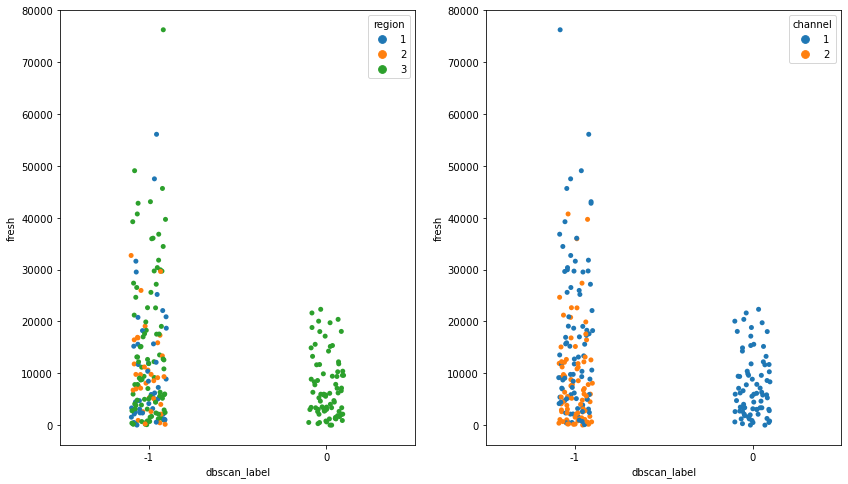

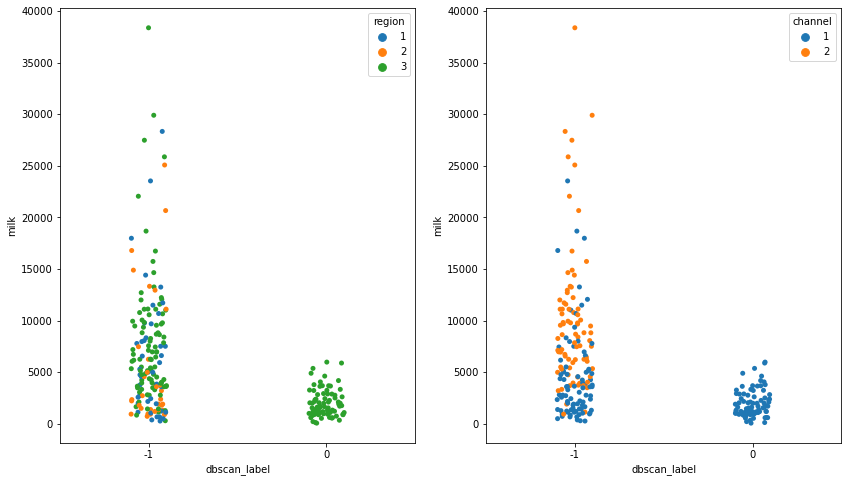

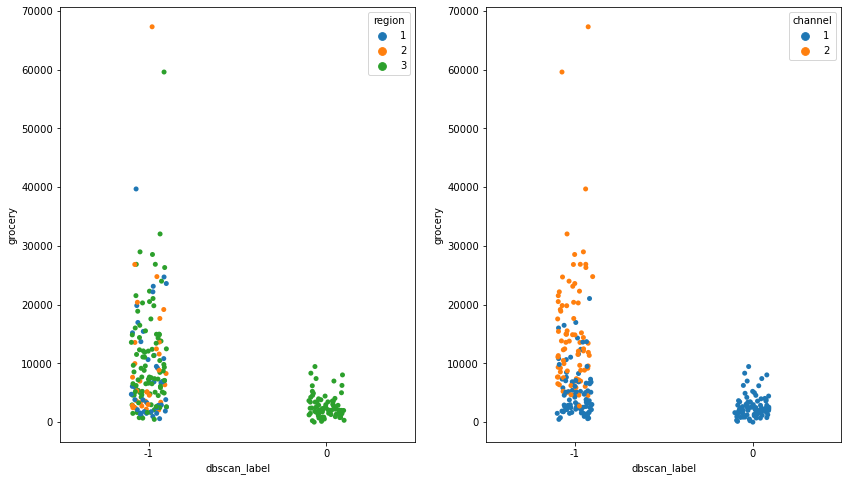

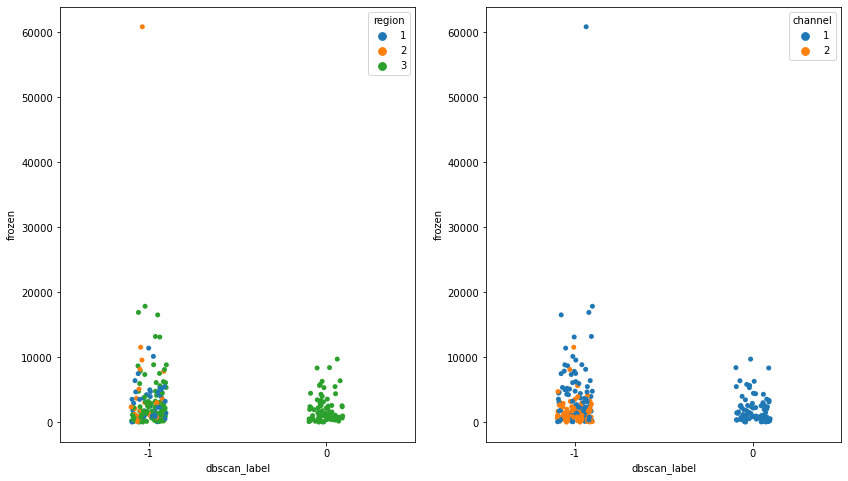

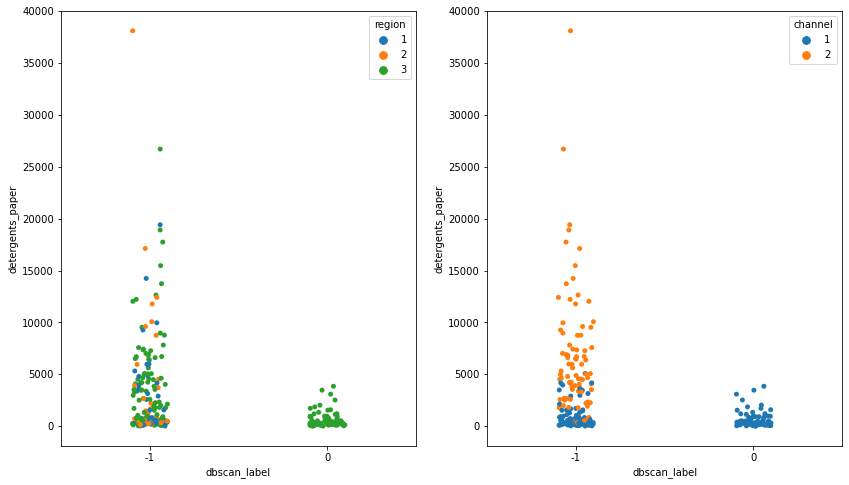

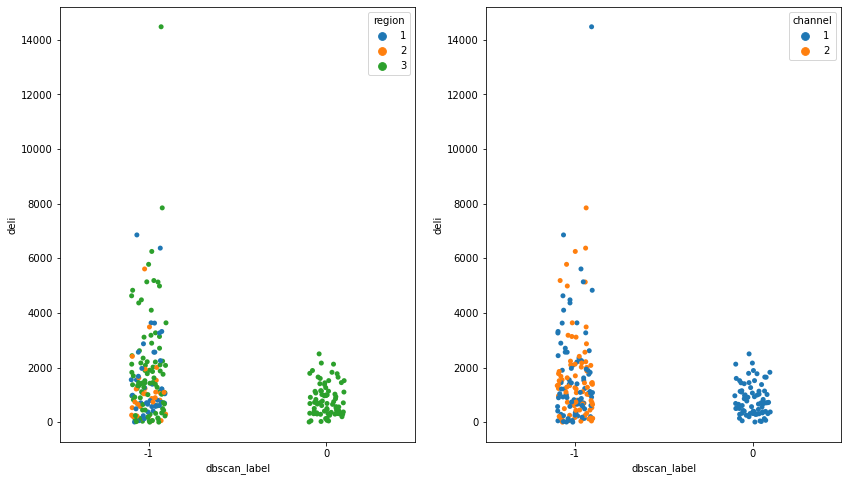

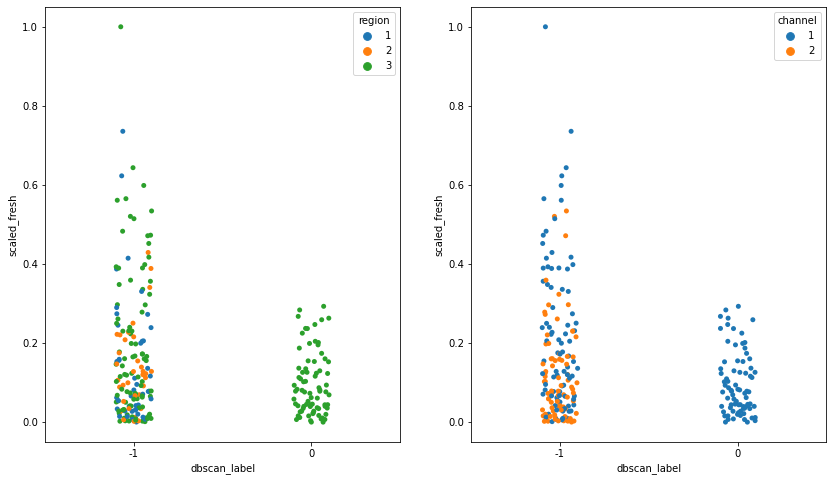

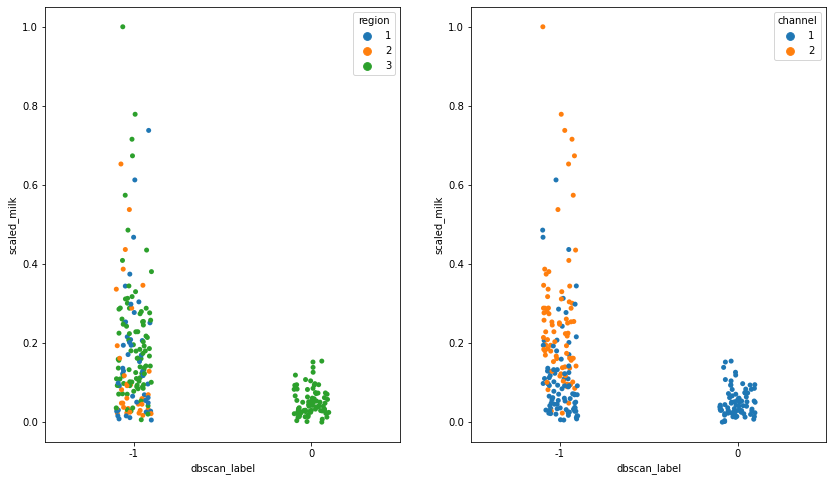

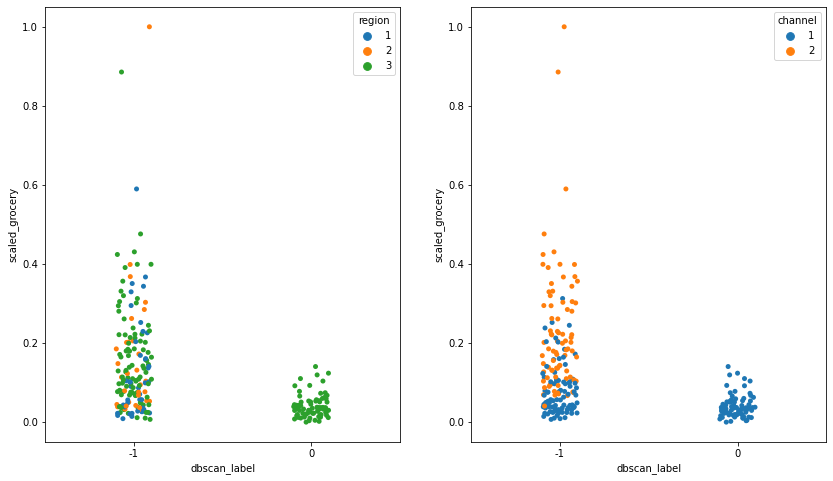

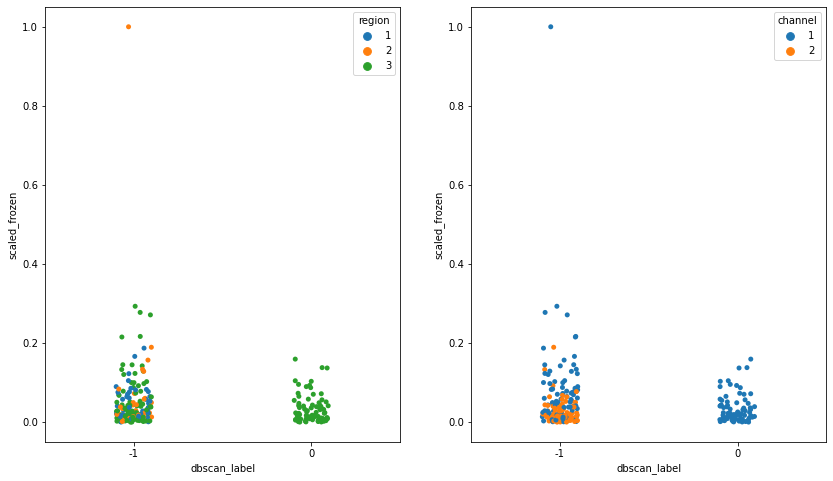

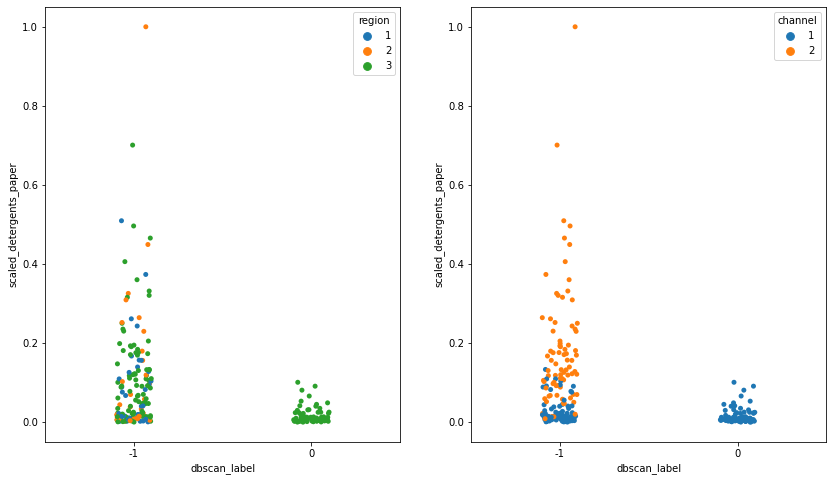

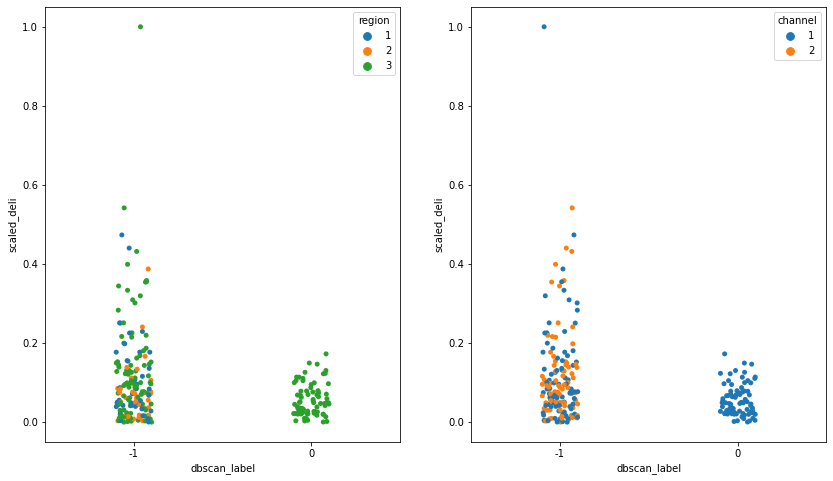

In [23]:
#Rename 'scaled_labels' column
g_train = g_train.rename(columns= {'scaled_labels': 'dbscan_label'})
#Cast dbscan_label dtype as 'object'
g_train.dbscan_label = g_train.dbscan_label.astype('object')
#Viz continuous variables against cluster labels
for col in g_train.select_dtypes(include=(np.int64, np.float64)).columns:
    plt.figure(figsize=(14,8))
    plt.subplot(121)
    sns.stripplot(data= g_train, x='dbscan_label', y=col, hue='region')
    plt.subplot(122)
    sns.stripplot(data= g_train, x='dbscan_label', y=col, hue='channel')
    plt.show()

### Takeaway:
Clusters homogenous for Region 3 and Channel 1

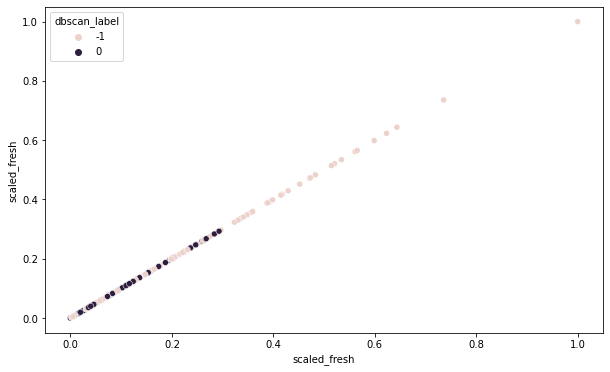

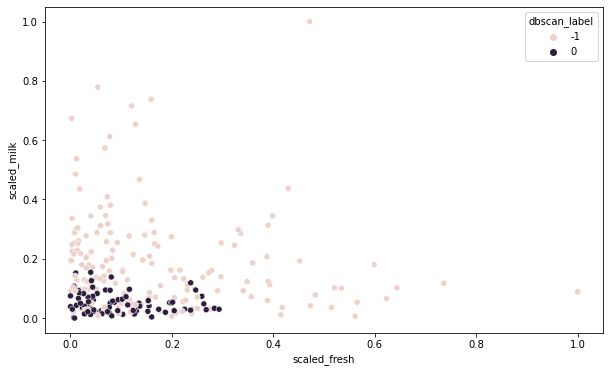

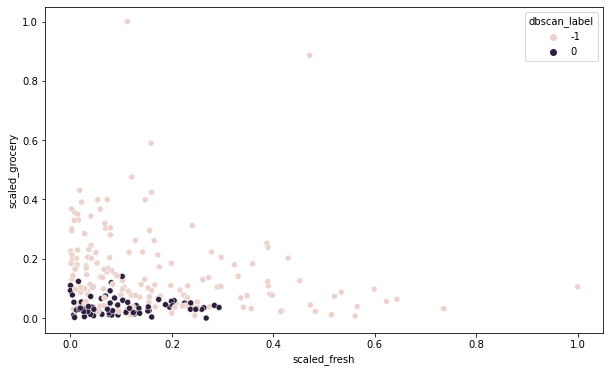

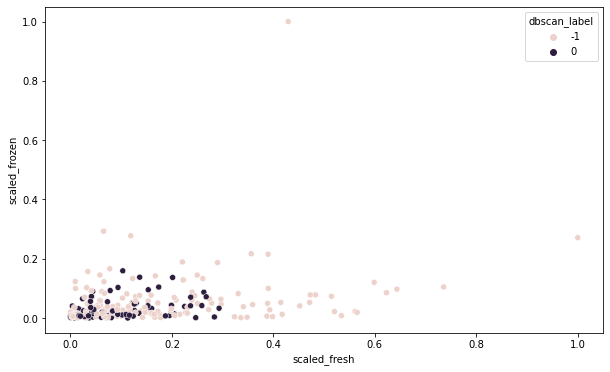

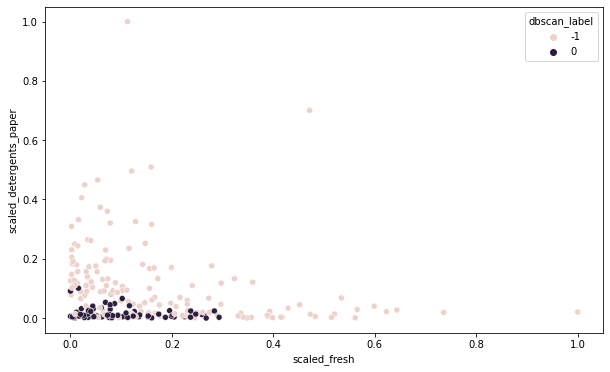

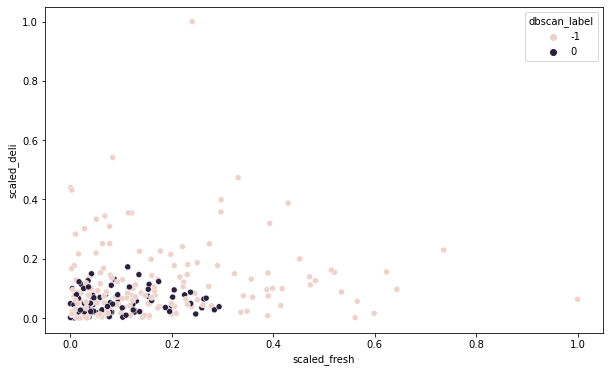

In [24]:
for col in g_train.select_dtypes(include=(np.float64)).columns:
    plt.figure(figsize=(10,6))
    sns.scatterplot(data= g_train, x='scaled_fresh', y=col, hue='dbscan_label')
    plt.show()
   

### Takeaway:
There seem to be more isolated data points than clustered ones. Adjust DBSCAN hyperparameters (epsilon and min_samples)

In [25]:
# DBSCAN adjustment 1
dbsc_adj1 = DBSCAN(eps= .50, min_samples=40)
dbsc_adj1.fit(g_train_scaled)
# Add new labels to scaled df
g_train_scaled['dbscan_adj1_labels'] = dbsc_adj1.labels_

#Check scaled df
g_train_scaled.head()
g_train['dbscan_adj1_labels'] = g_train_scaled.dbscan_adj1_labels

g_train.head()
g_train.info()
# Cast new labels column as 'object' in prep for viz
g_train.dbscan_adj1_labels = g_train.dbscan_adj1_labels.astype('object')
# Viz continuous variables vs. new cluster labels
for col in g_train.select_dtypes(include=(np.int64, np.float64)).columns:
    plt.figure(figsize=(14,8))
    plt.subplot(121)
    sns.stripplot(data= g_train, x='dbscan_adj1_labels', y=col, hue='region')
    plt.subplot(122)
    sns.stripplot(data= g_train, x='dbscan_adj1_labels', y=col, hue='channel')
    plt.show()


,scaled_channel,scaled_region,scaled_fresh,scaled_milk,scaled_grocery,scaled_frozen,scaled_detergents_paper,scaled_deli,scaled_labels,dbscan_adj1_labels
271,1,1,0.027284,0.129248,0.023182,0.017787,0.003780,0.106918,-1,-1
309,2,2,0.012003,0.537662,0.201560,0.023458,0.179611,0.055498,-1,-1
269,1,1,0.199583,0.005298,0.016866,0.040736,0.008662,0.013892,-1,-1
43,2,3,0.008225,0.288145,0.356564,0.012313,0.250033,0.004769,-1,0
401,1,3,0.356324,0.071671,0.031577,0.216748,0.002336,0.131246,-1,-1


### Takeaway:
New cluster appeared! Clusters 0 and 1 occupied by region 3, isolated datapoints from all three regions (-1). For channel variable, clear separation for clusters 0(channel 2) and 1(channel 1). 

In [32]:
g_train.dbscan_adj1_labels.value_counts()

-1    114
 1     78
 0     54
Name: dbscan_adj1_labels, dtype: int64

In [33]:
# DBSCAN adjustment 2
dbsc_adj2 = DBSCAN(eps=0.75, min_samples=50)
dbsc_adj2.fit(g_train_scaled)
# Add new labels to scaled df
g_train_scaled['dbscan_adj2_labels'] = dbsc_adj2.labels_

#Check scaled df
g_train_scaled.head()

,scaled_channel,scaled_region,scaled_fresh,scaled_milk,scaled_grocery,scaled_frozen,scaled_detergents_paper,scaled_deli,scaled_labels,dbscan_adj1_labels,dbscan_adj2_labels
271,1,1,0.027284,0.129248,0.023182,0.017787,0.003780,0.106918,-1,-1,-1
309,2,2,0.012003,0.537662,0.201560,0.023458,0.179611,0.055498,-1,-1,-1
269,1,1,0.199583,0.005298,0.016866,0.040736,0.008662,0.013892,-1,-1,-1
43,2,3,0.008225,0.288145,0.356564,0.012313,0.250033,0.004769,-1,0,0
401,1,3,0.356324,0.071671,0.031577,0.216748,0.002336,0.131246,-1,-1,-1


In [35]:
g_train['dbscan_adj2_labels'] = g_train_scaled.dbscan_adj2_labels

g_train.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli,scaled_fresh,scaled_milk,scaled_grocery,scaled_frozen,scaled_detergents_paper,scaled_deli,dbscan_label,dbscan_adj1_labels,dbscan_adj2_labels
271,1,1,2083,5007,1563,1120,147,1550,0.027284,0.129248,0.023182,0.017787,0.003780,0.106918,-1,-1,-1
309,2,2,918,20655,13567,1465,6846,806,0.012003,0.537662,0.201560,0.023458,0.179611,0.055498,-1,-1,-1
269,1,1,15218,258,1138,2516,333,204,0.199583,0.005298,0.016866,0.040736,0.008662,0.013892,-1,-1,-1
43,2,3,630,11095,23998,787,9529,72,0.008225,0.288145,0.356564,0.012313,0.250033,0.004769,-1,0,0
401,1,3,27167,2801,2128,13223,92,1902,0.356324,0.071671,0.031577,0.216748,0.002336,0.131246,-1,-1,-1


In [36]:
g_train.dbscan_adj2_labels.value_counts()

-1    114
 1     78
 0     54
Name: dbscan_adj2_labels, dtype: int64

In [37]:
# DBSCAN adjustment 3
dbsc_adj3 = DBSCAN(eps=1.5, min_samples=70)
dbsc_adj3.fit(g_train_scaled)
# Add new labels to scaled df
g_train_scaled['dbscan_adj3_labels'] = dbsc_adj3.labels_

#Check scaled df
g_train_scaled.head()

,scaled_channel,scaled_region,scaled_fresh,scaled_milk,scaled_grocery,scaled_frozen,scaled_detergents_paper,scaled_deli,scaled_labels,dbscan_adj1_labels,dbscan_adj2_labels,dbscan_adj3_labels
271,1,1,0.027284,0.129248,0.023182,0.017787,0.003780,0.106918,-1,-1,-1,0
309,2,2,0.012003,0.537662,0.201560,0.023458,0.179611,0.055498,-1,-1,-1,0
269,1,1,0.199583,0.005298,0.016866,0.040736,0.008662,0.013892,-1,-1,-1,0
43,2,3,0.008225,0.288145,0.356564,0.012313,0.250033,0.004769,-1,0,0,-1
401,1,3,0.356324,0.071671,0.031577,0.216748,0.002336,0.131246,-1,-1,-1,0


In [38]:
g_train_scaled.dbscan_adj3_labels.value_counts()

 0    114
 1     78
-1     54
Name: dbscan_adj3_labels, dtype: int64

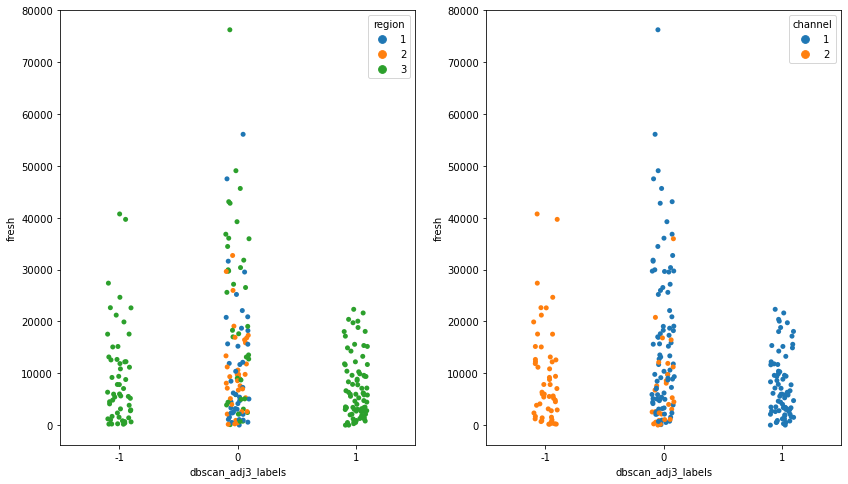

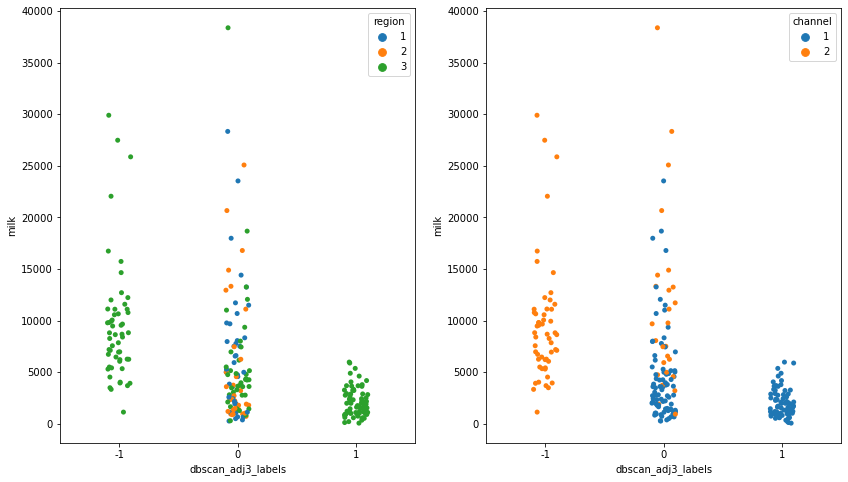

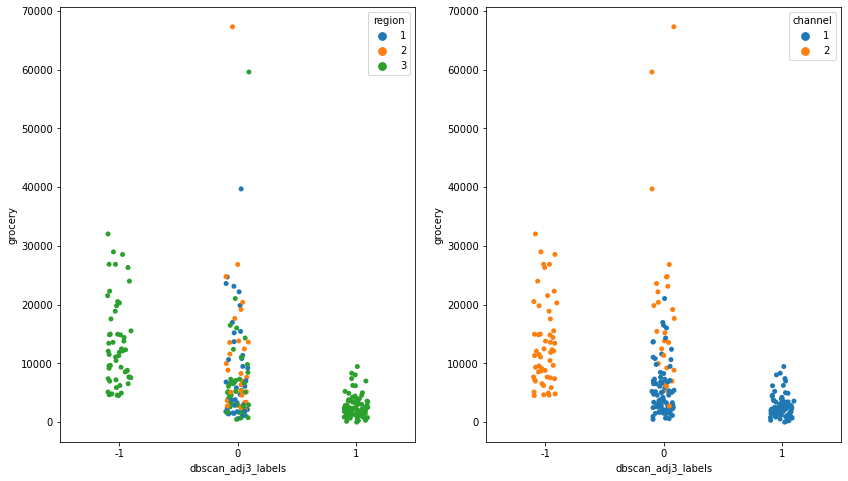

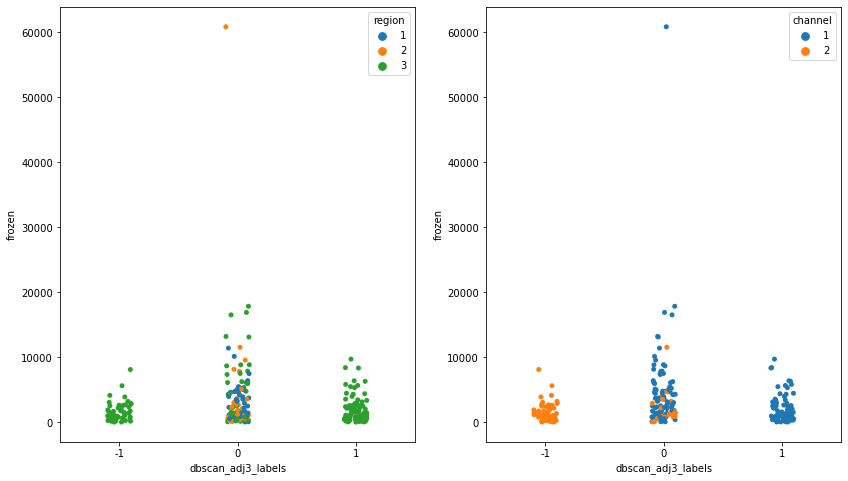

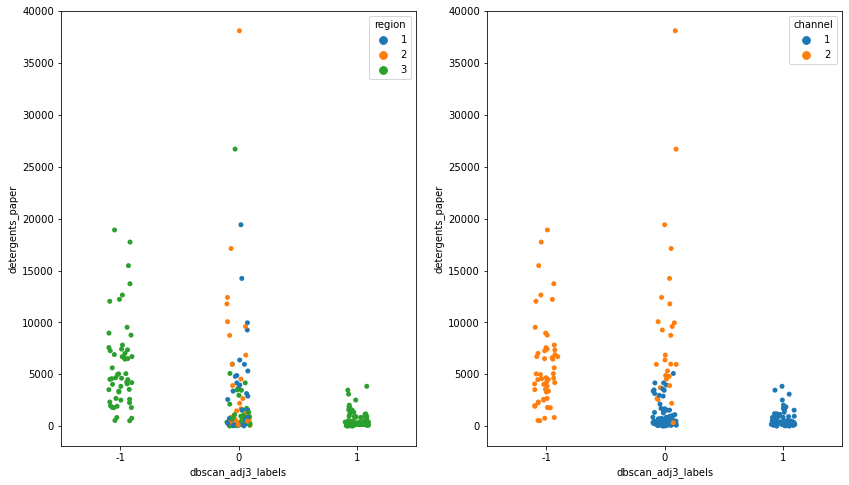

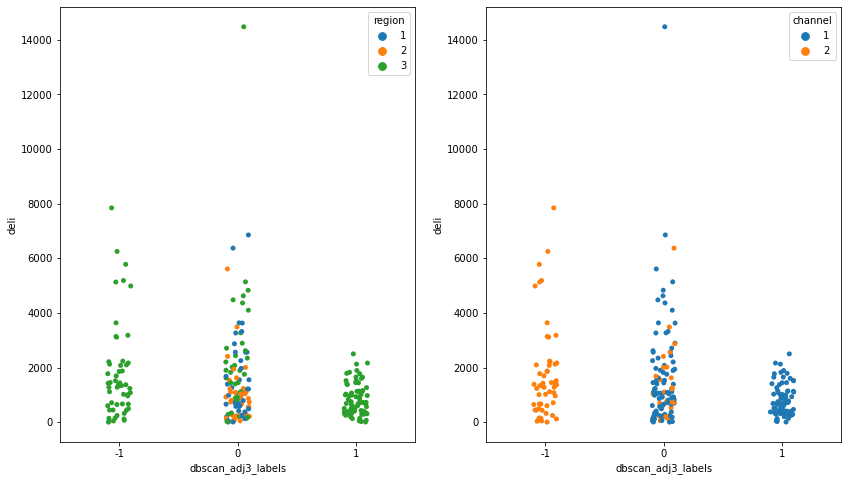

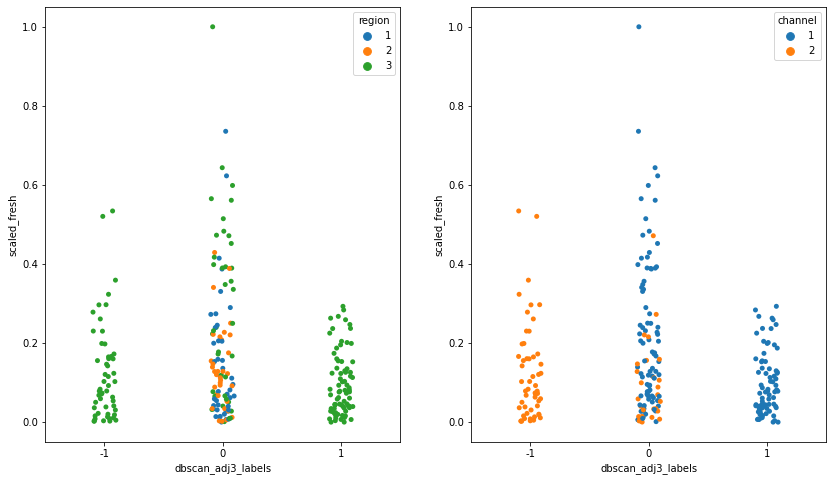

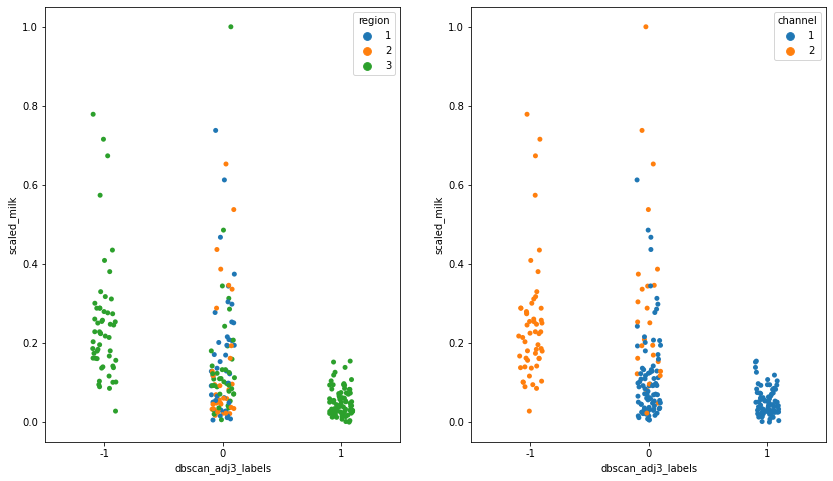

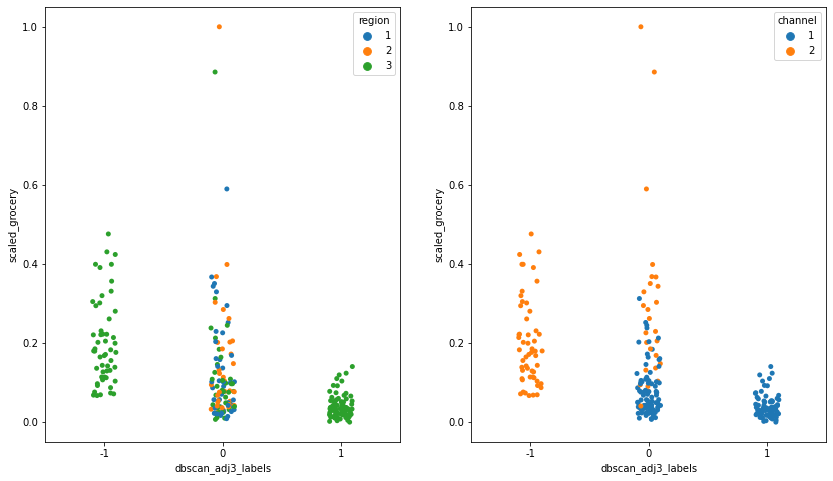

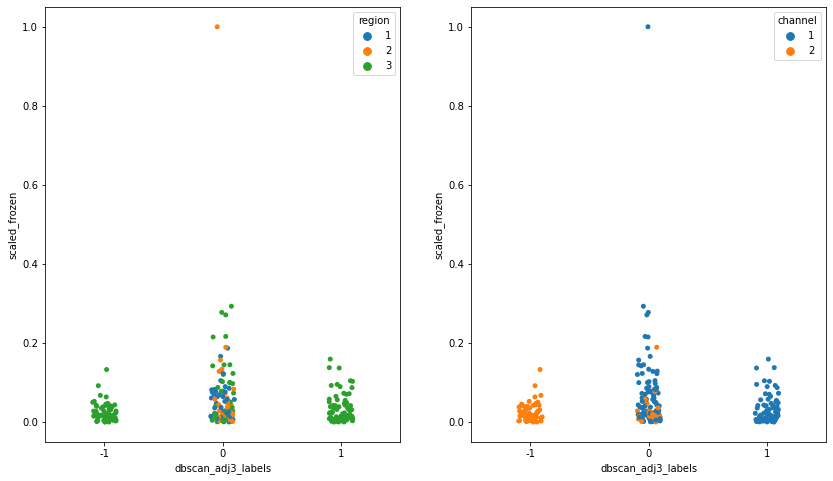

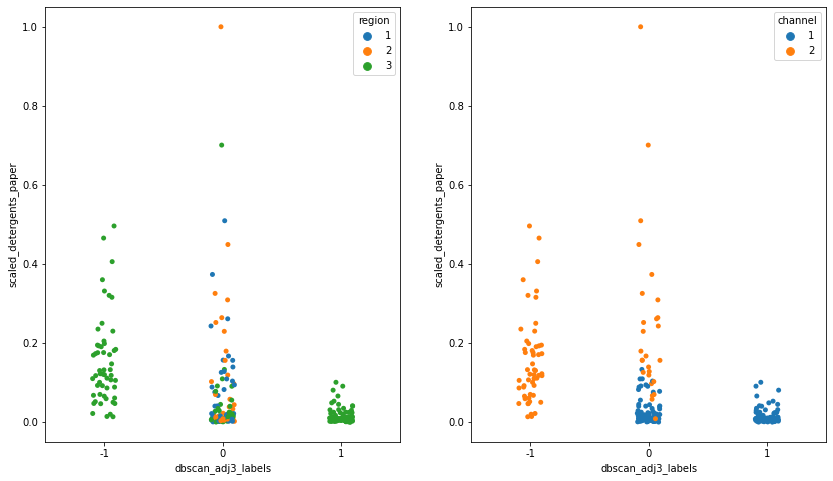

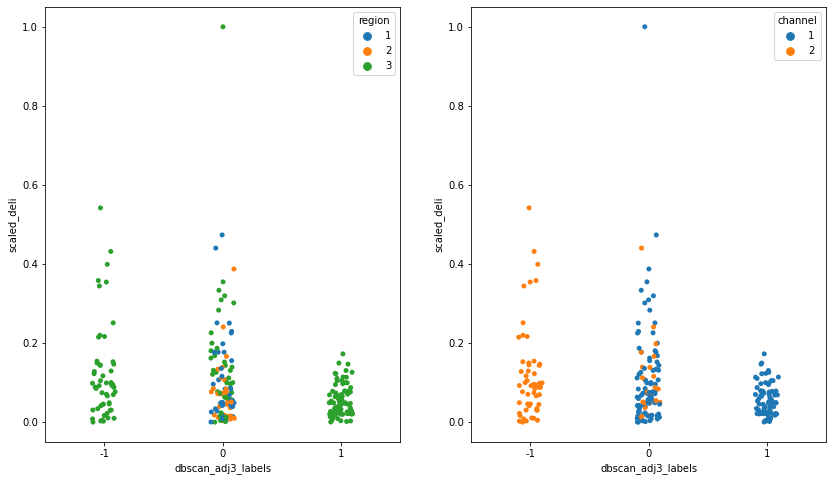

In [39]:
g_train['dbscan_adj3_labels'] = g_train_scaled.dbscan_adj3_labels

# Cast new labels column as 'object' in prep for viz
g_train.dbscan_adj2_labels = g_train.dbscan_adj2_labels.astype('object')
g_train.dbscan_adj3_labels = g_train.dbscan_adj3_labels.astype('object')
# Viz continuous variables vs. new cluster labels
for col in g_train.select_dtypes(include=(np.int64, np.float64)).columns:
    plt.figure(figsize=(14,8))
    plt.subplot(121)
    sns.stripplot(data= g_train, x='dbscan_adj3_labels', y=col, hue='region')
    plt.subplot(122)
    sns.stripplot(data= g_train, x='dbscan_adj3_labels', y=col, hue='channel')
    plt.show()



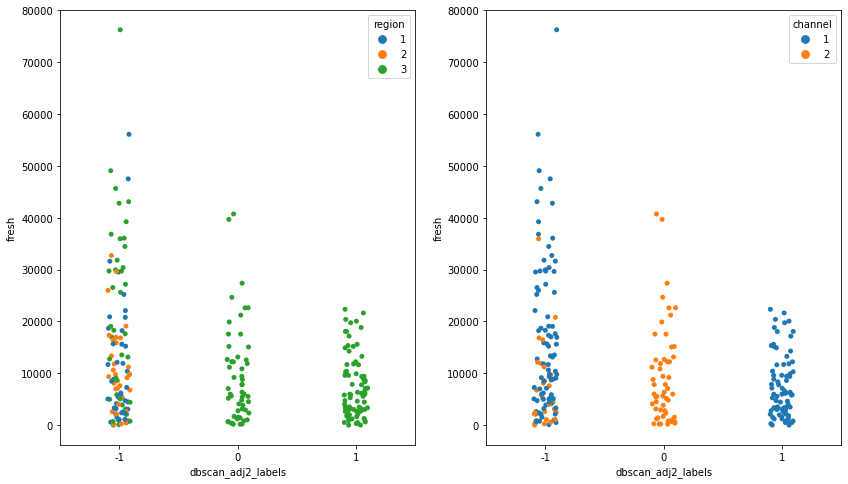

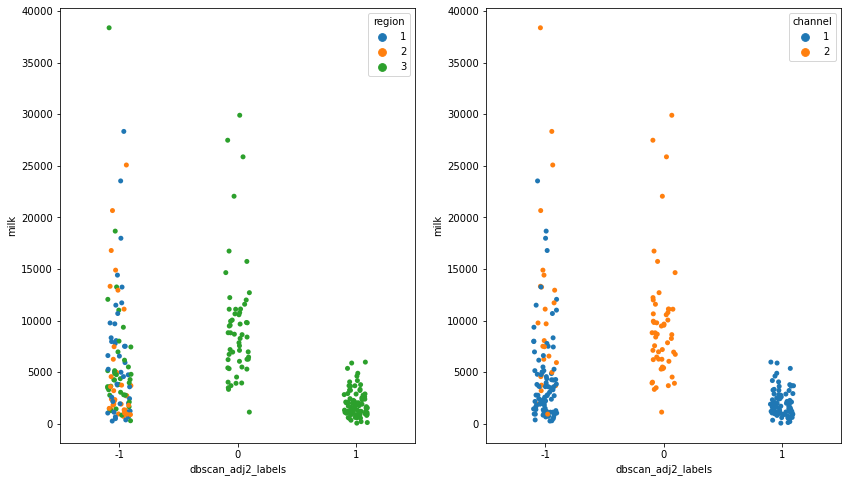

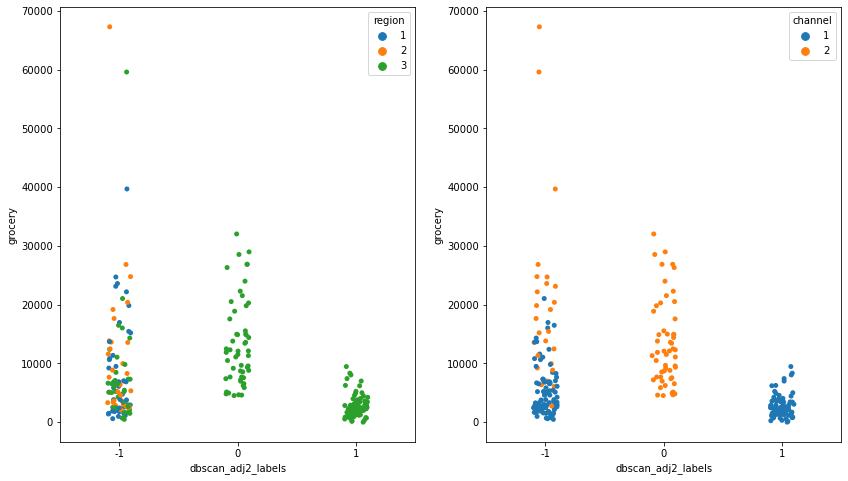

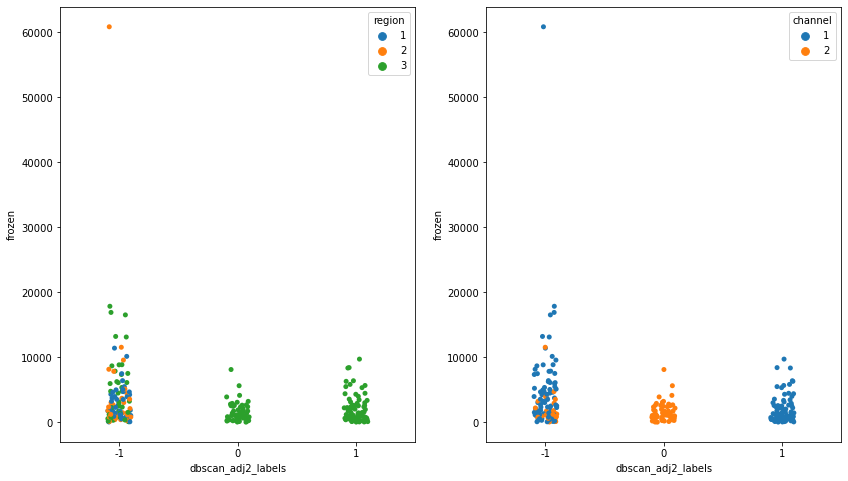

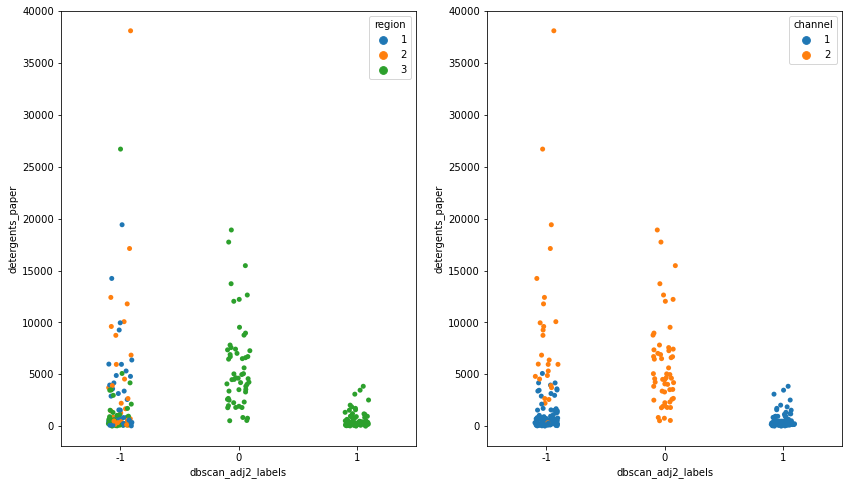

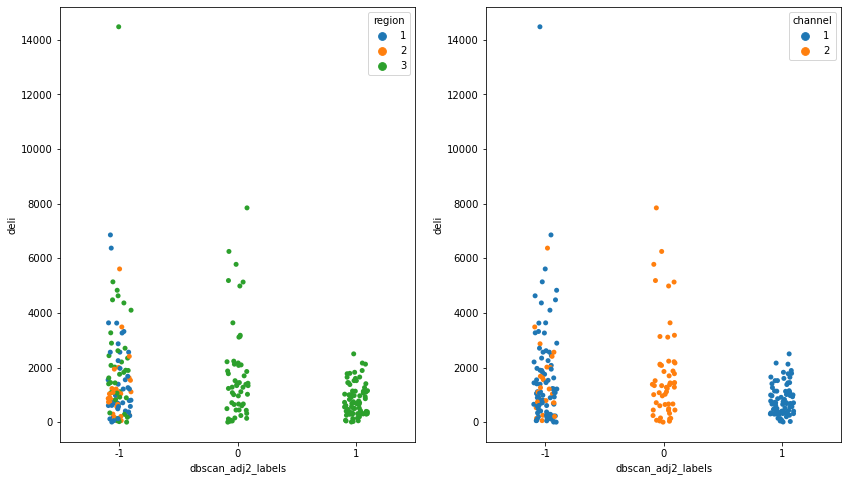

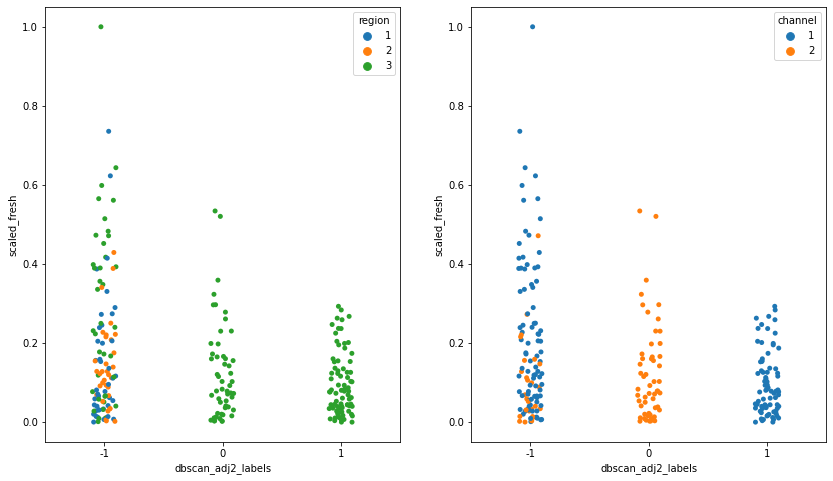

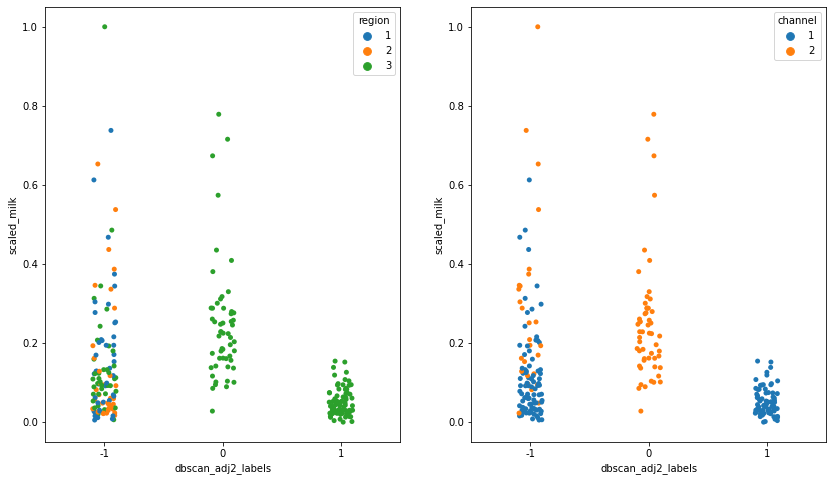

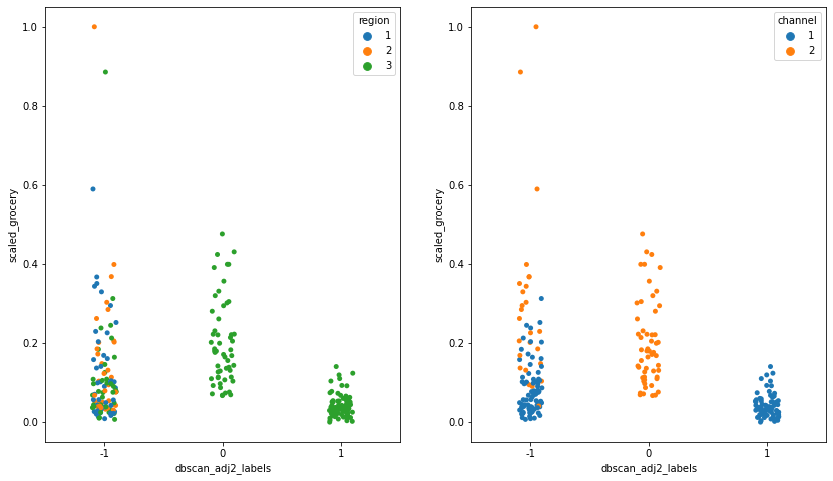

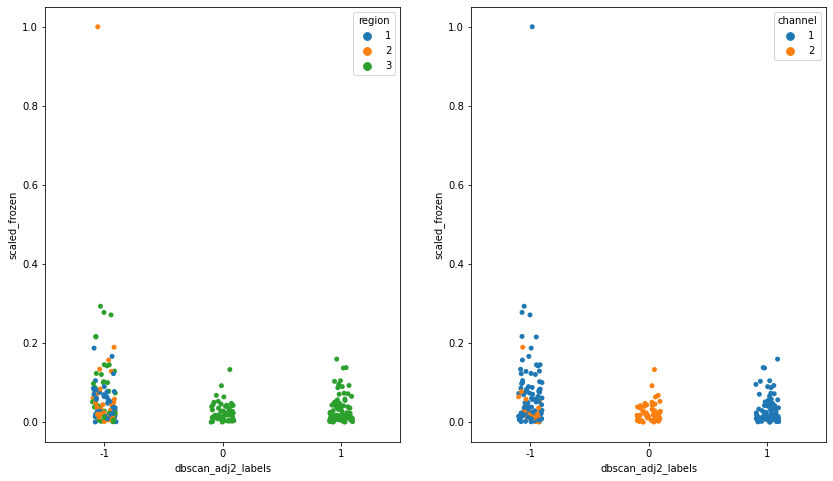

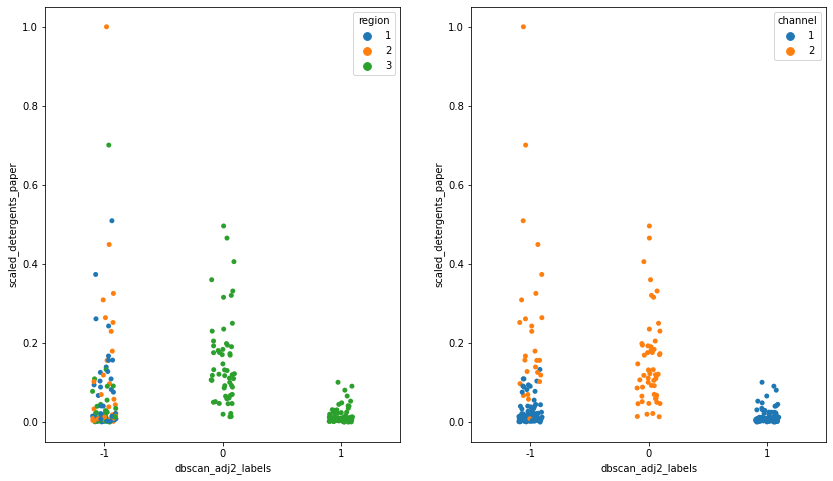

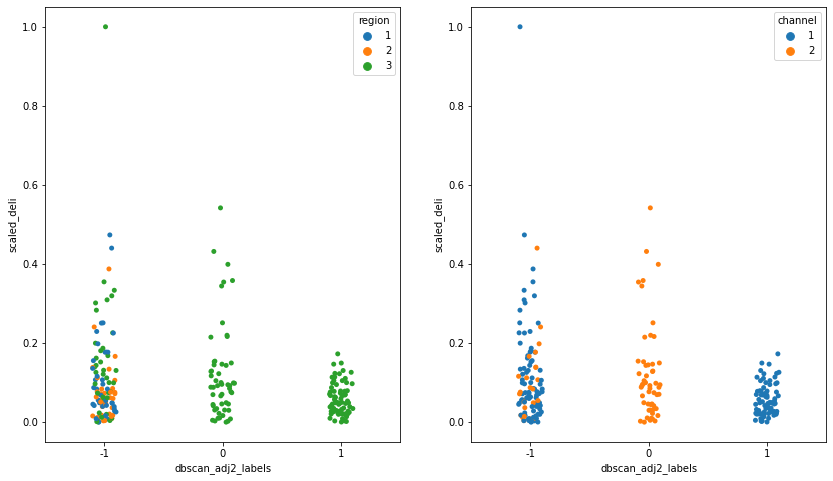

In [40]:
# Viz continuous variables vs. new cluster labels
for col in g_train.select_dtypes(include=(np.int64, np.float64)).columns:
    plt.figure(figsize=(14,8))
    plt.subplot(121)
    sns.stripplot(data= g_train, x='dbscan_adj2_labels', y=col, hue='region')
    plt.subplot(122)
    sns.stripplot(data= g_train, x='dbscan_adj2_labels', y=col, hue='channel')
    plt.show()